## 1. Data Upload

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
file_path = '/gdrive/MyDrive/Colab Notebooks/IMDB/IMDB_Train.csv'
df = pd.read_csv(file_path)

In [4]:
df.head()

,review,sentiment
0,"As much as I love trains, I couldn't stomach t...",negative
1,"This was a very good PPV, but like Wrestlemani...",positive
2,Not finding the right words is everybody's pro...,negative
3,I'm really suprised this movie didn't get a hi...,positive
4,I'll start by confessing that I tend to really...,negative


In [5]:
df.describe()

,review,sentiment
count,35000,35000
unique,34806,2
top,Loved today's show!!! It was a variety and not...,negative
freq,4,17589


In [6]:
df['sentiment'].value_counts()

,count
sentiment,
negative,17589
positive,17411


## 2. Data Preprocessing

In [7]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [8]:
df['clean_review'] = df['review'].apply(preprocess_text)

df[['review', 'clean_review']].head()

,review,clean_review
0,"As much as I love trains, I couldn't stomach t...",much love train stomach movie premise one coul...
1,"This was a very good PPV, but like Wrestlemani...",good ppv like wrestlemania xx year later wwe c...
2,Not finding the right words is everybody's pro...,finding right word everybody problem vaudevill...
3,I'm really suprised this movie didn't get a hi...,really suprised movie get higher rating imdb o...
4,I'll start by confessing that I tend to really...,start confessing tend really enjoy action movi...


## 3. Tokenization

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train = tfidf_vectorizer.fit_transform(df['clean_review'])
y_train = df['sentiment'].map({'positive': 1, 'negative': 0})

print(X_train.shape)

(35000, 5000)


In [10]:
# validation dataset
val_df = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/IMDB/IMDB_Validation.csv')
val_df['clean_review'] = val_df['review'].apply(preprocess_text)
X_val = tfidf_vectorizer.transform(val_df['clean_review'])
y_val = val_df['sentiment'].map({'positive': 1, 'negative': 0})

# test dataset
test_df = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/IMDB/IMDB_Test.csv')
test_df['clean_review'] = test_df['review'].apply(preprocess_text)
X_test = tfidf_vectorizer.transform(test_df['clean_review'])
y_test = test_df['sentiment'].map({'positive': 1, 'negative': 0})

## 4-1. Logistic Regression (ML)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialization
lr_model = LogisticRegression(max_iter=1000)

# Model training
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [12]:
# Validation dataset prediction
y_val_pred = lr_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_val, y_val_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_val, y_val_pred))

Validation Accuracy: 0.8860
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      3689
           1       0.88      0.90      0.89      3811

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500

Confusion Matrix:
[[3230  459]
 [ 396 3415]]


In [13]:
# Test dataset prediction
y_test_pred = lr_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8928


## 4-2. LSTM (DL)

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import numpy as np

In [27]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['clean_review'])

X_train_seq = tokenizer.texts_to_sequences(df['clean_review'])
X_val_seq = tokenizer.texts_to_sequences(val_df['clean_review'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_review'])

In [28]:
max_seq_length = int(np.percentile([len(x) for x in X_train_seq], 95))

X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_seq_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length, padding='post')

In [29]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_seq_length))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 274, 128)          1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
epochs = 5
batch_size = 128

history = model.fit(
    X_train_pad,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_pad, y_val),
    verbose=1
)

Epoch 1/5
274/274 [==============================] - 74s 265ms/step - loss: 0.6935 - accuracy: 0.5020 - val_loss: 0.6927 - val_accuracy: 0.5096
Epoch 2/5
274/274 [==============================] - 72s 264ms/step - loss: 0.6892 - accuracy: 0.5145 - val_loss: 0.6888 - val_accuracy: 0.5016
Epoch 3/5
274/274 [==============================] - 73s 265ms/step - loss: 0.7061 - accuracy: 0.5240 - val_loss: 0.6884 - val_accuracy: 0.5021
Epoch 4/5
274/274 [==============================] - 72s 263ms/step - loss: 0.6751 - accuracy: 0.5350 - val_loss: 0.7222 - val_accuracy: 0.4935
Epoch 5/5
274/274 [==============================] - 72s 264ms/step - loss: 0.6781 - accuracy: 0.5229 - val_loss: 0.6457 - val_accuracy: 0.5019


In [33]:
# validation dataset
val_loss, val_accuracy = model.evaluate(X_val_pad, y_val, verbose=0)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# test dataset
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')

Validation Accuracy: 0.5019
Test Accuracy: 0.5159


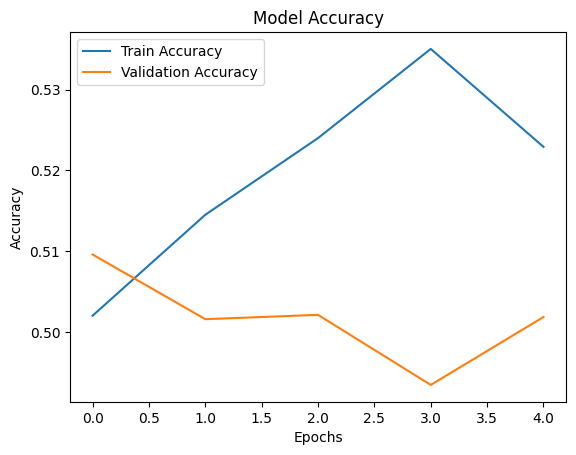

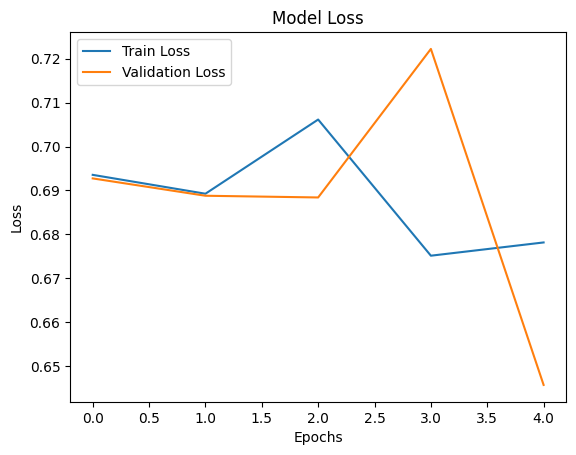

In [34]:
import matplotlib.pyplot as plt

# Accuracy Visualization
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Visualization
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Detect Overfitting. So, let's fix it.

In [39]:
# 1. Simplify Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = nltk.word_tokenize(text)
    return ' '.join(words)

df['clean_review'] = df['review'].apply(preprocess_text)
val_df['clean_review'] = val_df['review'].apply(preprocess_text)
test_df['clean_review'] = test_df['review'].apply(preprocess_text)

# 2. Add oov_token: to the Tokenizer to map out-of-vocabulary words to a specific token
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_review'])

X_train_seq = tokenizer.texts_to_sequences(df['clean_review'])
X_val_seq = tokenizer.texts_to_sequences(val_df['clean_review'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_review'])

# 3. Reduced fixed maximum sequence length to prevent overfitting
max_seq_length = 200

X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_seq_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length, padding='post')

# 4. Simplify Model architecture by decreasing the number of LSTM units
model = Sequential()
model.add(Embedding(input_dim=20001, output_dim=128, input_length=max_seq_length))
model.add(LSTM(
    units=32,
    dropout=0.5,
    recurrent_dropout=0.5,
    kernel_regularizer=l2(0.02)
))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.02)))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 5. Increase batch sizes to improve generalization
history = model.fit(
    X_train_pad,
    y_train,
    epochs=15,
    batch_size=256,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping],
    verbose=1
)

test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/15
137/137 [==============================] - 31s 209ms/step - loss: 2.0530 - accuracy: 0.5691 - val_loss: 1.1387 - val_accuracy: 0.7764
Epoch 2/15
137/137 [==============================] - 29s 210ms/step - loss: 0.7643 - accuracy: 0.8331 - val_loss: 0.5115 - val_accuracy: 0.8721
Epoch 3/15
137/137 [==============================] - 28s 208ms/step - loss: 0.4380 - accuracy: 0.8859 - val_loss: 0.4295 - val_accuracy: 0.8755
Epoch 4/15
137/137 [==============================] - 28s 206ms/step - loss: 0.3762 - accuracy: 0.8952 - val_loss: 0.4426 - val_accuracy: 0.8641
Epoch 5/15
137/137 [==============================] - 28s 207ms/step - loss: 0.3313 - accuracy: 0.9100 - val_loss: 0.4557 - val_accuracy: 0.8637
Epoch 6/15
137/137 [==============================] - 29s 208ms/step - loss: 0.3130 - accuracy: 0.9146 - val_loss: 0.4190 - val_accuracy: 0.8732
Epoch 7/15
137/137 [==============================] - 28s 206ms/step - loss: 0.2887 - accuracy: 0.9233 - val_loss: 0.4174 - val_ac

In [40]:
# validation dataset
val_loss, val_accuracy = model.evaluate(X_val_pad, y_val, verbose=0)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# test dataset
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')

Validation Accuracy: 0.8756
Test Accuracy: 0.8853


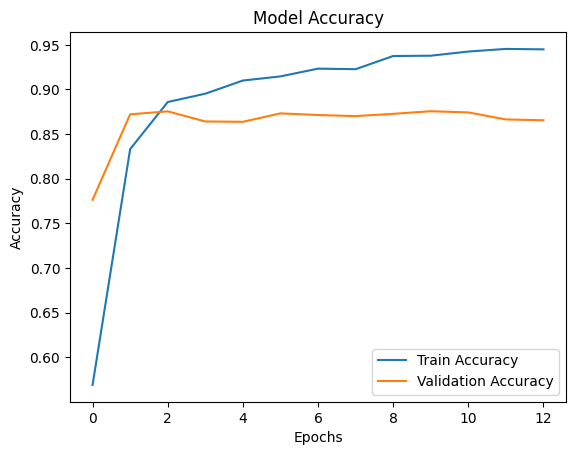

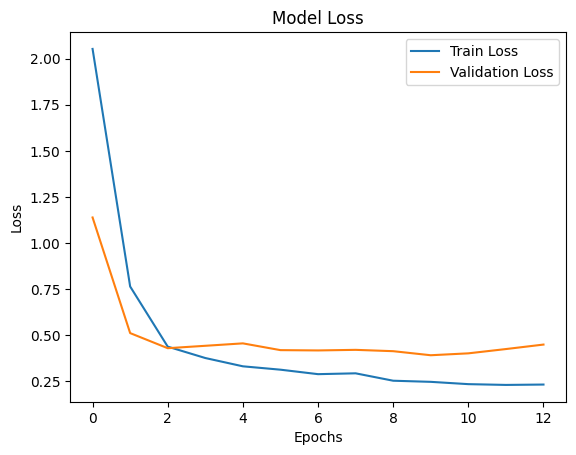

In [41]:
import matplotlib.pyplot as plt

# Accuracy Visualization
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Visualization
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()